<a href="https://colab.research.google.com/github/Sugandh-Mishra/attacks/blob/main/cw.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import tensorflow as tf
from tensorflow import keras
from matplotlib import pyplot as plt
from tensorflow.keras import layers, models, datasets
import numpy as np

In [ ]:
def train_model():
    (train_images, train_labels), (test_images, test_labels) = datasets.mnist.load_data()
    train_images = train_images.reshape((60000, 28, 28, 1)).astype('float32') / 255.0
    test_images = test_images.reshape((10000, 28, 28, 1)).astype('float32') / 255.0
    
    model = models.Sequential([
        layers.Conv2D(32, (3, 3), activation='relu', input_shape=(28, 28, 1)),
        layers.MaxPooling2D((2, 2)),
        layers.Conv2D(64, (3, 3), activation='relu',padding='same'),
        layers.MaxPooling2D((2, 2)),
        layers.Flatten(),
        layers.Dense(128, activation='relu'),
        layers.Dense(10, activation='softmax')
    ])

    model.compile(optimizer='adam',
                  loss='sparse_categorical_crossentropy',
                  metrics=['accuracy'])

    model.fit(train_images, train_labels, epochs=2, validation_data=(test_images, test_labels))
  
    return model, test_images, test_labels, train_images

In [ ]:
# Train the model
model, test_images, test_labels, x_train = train_model()


11490434/11490434 [==============================] - 1s 0us/step
Epoch 1/2
1875/1875 [==============================] - 21s 5ms/step - loss: 0.1243 - accuracy: 0.9613 - val_loss: 0.0467 - val_accuracy: 0.9836
Epoch 2/2
1875/1875 [==============================] - 7s 4ms/step - loss: 0.0396 - accuracy: 0.9874 - val_loss: 0.0383 - val_accuracy: 0.9870


In [ ]:
import numpy as np
from tensorflow.keras import backend as K
from tensorflow.keras.losses import BinaryCrossentropy
from tensorflow.keras.optimizers import Adam


def cw_loss(logits, labels, targeted=True, confidence=0, kappa=0):
    """
    Carlini-Wagner Loss function for targeted or untargeted attacks.

    Args:
        logits (tf.Tensor): Logits predicted by the model.
        labels (tf.Tensor): True labels for the images.
        targeted (bool): Whether the attack is targeted or untargeted. Default is True.
        confidence (float): Confidence parameter for targeted attacks. Default is 0.
        kappa (float): Kappa parameter for untargeted attacks. Default is 0.

    Returns:
        tf.Tensor: Carlini-Wagner Loss.
    """
    # Compute the predicted probabilities
    probs = tf.nn.softmax(logits)

    if targeted:
        # Targeted attack: maximize the probability of the target label
        target_probs = tf.reduce_sum(probs * labels, axis=1)
        other_probs = tf.reduce_max(probs * (1 - labels) - (labels * 10000), axis=1)  # Set other class probabilities to a very small negative value
        loss = tf.reduce_mean(tf.maximum(0.0, other_probs - target_probs + confidence))

    else:
        # Untargeted attack: maximize the margin between the predicted class and the next best class
        top_logits = tf.reduce_max(probs * labels, axis=1)
        second_best_logits = tf.reduce_max(probs * (1 - labels) - (labels * 10000), axis=1)  # Set other class probabilities to a very small negative value
        loss = tf.reduce_mean(tf.maximum(0.0, top_logits - second_best_logits + kappa))

    return loss

def cw_attack(model, test_images, test_labels, epsilon=0.1, max_iterations=100, targeted=True, target_label=None):
    adv_images = []
    adv_probs = []
    adv_labels = []
    for i in range(test_images.shape[0]):
        image = test_images[i]
        label = test_labels[i]

        if targeted:
            if target_label is None:
                raise ValueError("When targeted=True, target_label must be provided.")
            else:
                y_true = np.zeros((1, 10))
                y_true[0][target_label] = 1
                y_true = tf.convert_to_tensor(y_true, dtype=tf.float32)
        else:
            y_true = tf.convert_to_tensor(label, dtype=tf.float32)
            
        image = tf.convert_to_tensor(image, dtype=tf.float32)
        image = tf.expand_dims(image, axis=0)

        for j in range(max_iterations):
            with tf.GradientTape() as tape:
                tape.watch(image)
                logits = model(image)
                loss = cw_loss(logits, y_true, targeted)
            gradients = tape.gradient(loss, image)
            image = image - epsilon * tf.sign(gradients)
            image = tf.clip_by_value(image, clip_value_min=0, clip_value_max=1)

        adv_images.append(image.numpy().squeeze(axis=0))
        adv_probs.append(tf.nn.softmax(logits, axis=-1).numpy().squeeze(axis=0))
        adv_labels.append(tf.argmax(logits, axis=-1).numpy().squeeze())

    adv_images = np.array(adv_images)
    adv_probs = np.array(adv_probs)
    adv_labels = np.array(adv_labels)
    return adv_images, adv_probs, adv_labels



In [ ]:
# Generate adversarial images using CW attack
adv_images,adv_probs,adv_labels = cw_attack(model, test_images, test_labels, epsilon=0.1, max_iterations=2, targeted=True, target_label=5)

# Evaluate the accuracy of the model on the original test images
_, test_accuracy = model.evaluate(test_images, test_labels, verbose=0)
print(f"Accuracy on original test images: {test_accuracy}")

# Evaluate the accuracy of the model on the adversarial images
_, adv_accuracy = model.evaluate(adv_images, test_labels, verbose=0)
print(f"Accuracy on adversarial images: {adv_accuracy}")


Accuracy on original test images: 0.9869999885559082
Accuracy on adversarial images: 0.42579999566078186


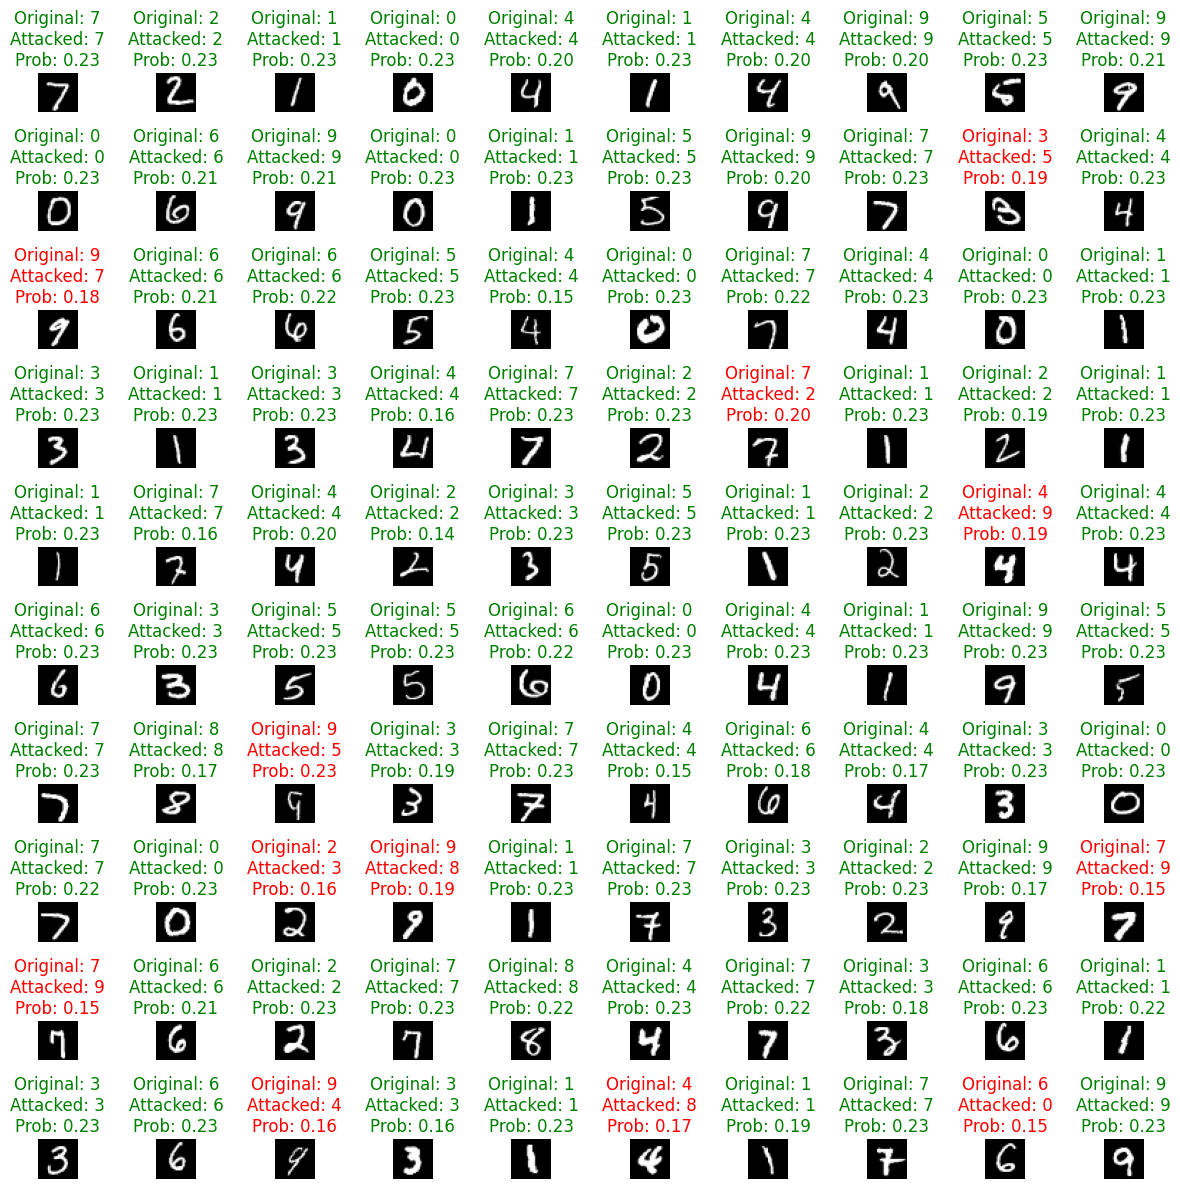

In [ ]:
def visualize_cw_attack(original_images, attacked_images, original_labels, attacked_labels, probs):
    num_images = len(original_images)
    num_rows = 10
    num_cols = 10
    fig, axes = plt.subplots(num_rows, num_cols, figsize=(12, 12))

    for i in range(num_rows):
        for j in range(num_cols):
            index = i * num_cols + j
            if index < num_images:
                axes[i][j].imshow(original_images[index].reshape(28, 28), cmap='gray')
                axes[i][j].axis('off')
                if attacked_labels[index] == original_labels[index]:
                    axes[i][j].set_title(f'Original: {original_labels[index]}\nAttacked: {attacked_labels[index]}\nProb: {probs[index][attacked_labels[index]]:.2f}', color='green')
                else:
                    axes[i][j].set_title(f'Original: {original_labels[index]}\nAttacked: {attacked_labels[index]}\nProb: {probs[index][attacked_labels[index]]:.2f}', color='red')
            else:
                axes[i][j].axis('off')
    plt.tight_layout()
    plt.show()


visualize_cw_attack(test_images,adv_images,test_labels,adv_labels,adv_probs)